# Advanced Skills

## 1. Downsizing data with a specific ratio

### 1) Introduction
Have you thought that given data with 5 labels, you can also do a binary classification? For example, we have 5 jets: t, q, g, w, z. Now instead of 5 Tagger, we only want to do the T Tagger, which means all the other jets are clustered to not-T. In this case, if we directly use the data, it results in input imbalance: T is only 1/4 of not-T. Thus we need to downsize the data so that elements are relatively balanced.<br><br>
Additionally, for testing, we usually use part of the data, so downsizing is very necessary.



### 2) Code
Generally we use the conditional silicing in pandas to accomplish this task.

In [6]:
import numpy as np
import h5py
import pandas as pd
from tqdm import tqdm

# load data
load_path = "data/samples.h5"
df = pd.read_hdf(load_path, key="data")   

In [7]:
# Locate the data who meets the condition
tJets = df[df['j_t']==1]

print("There are %d constituents of T jets." %(tJets.shape[0]))

There are 6997 constituents of T jets.


However, we cannot directly split this Series. Instead, we want to split the data by jets.

In [8]:
labels=['j_t','j_q','j_g','j_w','j_z']
jet_dict = {}
for label in labels:
    jet_dict[label] = np.unique(df[df[label]==1]['j_index'])

Now we have a dictionary in which keys are labels and values are correpsponding jet indices.<br>
Now lets take 10 for each jet.

In [9]:
jet_size = np.repeat([10],5)
df100 = pd.DataFrame()

for label, indices in jet_dict.items():
    chosen_jets = np.random.choice(indices,size=jet_size[labels.index(label)], replace=False)
    temp_df = df[df['j_index'].isin(chosen_jets)]
    df100 = pd.concat([df100,temp_df],axis=0)

df100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2540 entries, 1440 to 22296
Data columns (total 79 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              2540 non-null   object 
 1   j_ptfrac           2540 non-null   float32
 2   j_pt               2540 non-null   float32
 3   j_eta              2540 non-null   float32
 4   j_mass             2540 non-null   float32
 5   j_tau1_b1          2540 non-null   float32
 6   j_tau2_b1          2540 non-null   float32
 7   j_tau3_b1          2540 non-null   float32
 8   j_tau1_b2          2540 non-null   float32
 9   j_tau2_b2          2540 non-null   float32
 10  j_tau3_b2          2540 non-null   float32
 11  j_tau32_b1         2540 non-null   float32
 12  j_tau32_b2         2540 non-null   float32
 13  j_zlogz            2540 non-null   float32
 14  j_c1_b0            2540 non-null   float32
 15  j_c1_b1            2540 non-null   float32
 16  j_c1_b2            2

Here we have a dataset with 100 jets for each category.

### 3) Excercise
Try to create a dataset with 500 jets for total but with ratio t:q:g:z:w = 3:2:1:0:0.

## 2. N-Constituents of Jets
The amount of constituents varies in jets, ranging from 20 to more than 200. When we classify, we always expect to keep each jet containning the same number of constituents. For example, if we set nConstituents = 40, ranking by the transverse momentum (default), the first 40 constituents will be kept. If constituents in a jet are less than 40, we will use zero-padding.

In [10]:
def data_transform (nConstituents, data):
    kColumns = data.columns.shape[0]

    # we expect the output shape (mJets, nConstituents, kColumns)
    jet_list = list(set(data['j_index']))
    data_expected = []

    for jet in tqdm(jet_list):
        # Zero padding for insufficient jets. 
        # So we create a empty array and add signals in.
        jet_frame = np.zeros((nConstituents, kColumns))
        jet_temp = data[data['j_index']==jet].values
        if (jet_temp.shape[0]<nConstituents):
            for i, constituent in enumerate(jet_temp):
                jet_frame[i] = constituent
        else:
            jet_frame = jet_temp[:nConstituents] + jet_frame
        data_expected.append(jet_frame)
    # "j_index" is useless for machine learning part. Drop it!

    return np.array(data_expected)[:,:,:-1]

## 3. Jet Clustering & Rotating
### 1) Dependencies
You need Linux to run "pyjet". This is the tutorial to install WSL: [WSL Tutorial](https://github.com/451488975/Anaconda_Setup/blob/master/CPU_with_WSL.ipynb)

Make sure you have:
 - pyjet
<br>

### 2) Get low/high-level features
Sometimes we have data with 4-momenta form, either (e,px,py,pz) or (pT,eta,phi,mass). But we need more, such as etaRel,phiRel ...

In [11]:
from pyjet import cluster

def _load (filePath, nJets=200000, nConstituents=40):
    '''
    Returns:
        momenta: (nJets, 4, nConstituents)
    '''
    cols = ['E_'+str(i) for i in range(nConstituents)]+ ['PX_'+str(i) for i in range(nConstituents)] + ['PX_'+str(i) for i in range(nConstituents)] + ['PY_'+str(i) for i in range(nConstituents)] + ['PZ_'+str(i) for i in range(nConstituents)] + ['is_signal_new']

    df = pd.read_hdf(filePath,key='data',stop=nJets, columns = cols)
    # Take all the 4 momentum from 200 particles in all jets and reshape them into one particle per row
    momenta = df.iloc[:,:-1].to_numpy()
    momenta = momenta.reshape(-1,nConstituents,4)
    nJets = slice(nJets)
    momenta = momenta[nJets, :nConstituents, :]
    momenta = np.transpose(momenta, (0, 2, 1))
    label = df['is_signal_new']
    return momenta, label

ModuleNotFoundError: No module named 'pyjet'

In [3]:
filePath = "data/4m_samples.h5"
nJets = 100
nConstituents = 40
momenta,labels = _load(filePath,nJets , nConstituents)



In [4]:
def _getFeatures (momenta,nConstituents):
    # Jet features
    jetMomenta = np.sum(momenta, axis=2)
    jetPt = np.linalg.norm(jetMomenta[:, 1:3], axis=1)[..., np.newaxis]
    jetE = jetMomenta[:, 0][..., np.newaxis]
    jetP = np.linalg.norm(jetMomenta[:, 1:], axis=1)
    jetEta = 0.5 * np.log((jetP + jetMomenta[:, 3]) / (jetP - jetMomenta[:, 3]))[..., np.newaxis]
    jetPhi = np.arctan2(jetMomenta[:, 2], jetMomenta[:, 1])[..., np.newaxis]
    jetTheta = 2*np.arctan(np.exp(-jetEta))
    # Copy nConstituents times to match the shape (nJets, nConstituents).
    jetPt = np.tile(jetPt,nConstituents)
    jetE = np.tile(jetE,nConstituents)
    jetEta = np.tile(jetEta,nConstituents)
    jetPhi = np.tile(jetPhi,nConstituents)

    # Constituent features
    # delta eta, delta phi, log pT, log E,log pT / pTjet, log E / Ejet, delta R
    pT = np.linalg.norm(momenta[:, 1:3, :], axis=1)
    e = momenta[:, 0, :]
    p = np.linalg.norm(momenta[:, 1:, :], axis=1)
    mass = e**2- p**2
    # eta = 0.5 * np.log((p + momenta[:, 3, :]) / (p - momenta[:, 3, :]))
    eta = np.arcsinh(momenta[:,3,:]/pT)
    etaRel = eta - jetEta
    phi = np.arctan2(momenta[:, 2, :], momenta[:, 1, :])
    phiRel = np.unwrap(phi - jetPhi)
    dR = np.sqrt(phi ** 2 + eta ** 2)
    theta = 2*np.arctan(np.exp(-eta))
    cosThetaRel = np.cos(theta-jetTheta)
    
    # Concatenate
    # features = np.stack([jetPt, jetE, jetEta, jetPhi, pT, mass, e, eta, etaRel, phi, phiRel, dR, cosThetaRel],axis=-1)
    features = np.stack([pT,eta,phi,mass, etaRel, phiRel, e, dR, cosThetaRel, jetPt, jetE, jetEta, jetPhi],axis=-1)
    return features

In [6]:
features = _getFeatures(momenta,nConstituents)

NameError: name '_getFeatures' is not defined

### 3) Cluster and Rotate
Rotation is performed to remove the stochastic nature of the decay angle relative to the η − φ coordinate system. For two-body decay processes (such as the hadronic decay of a W boson) the direction connecting the axes of the leading two subjets can be rotated until the leading subject is directly above the subleading subjet.
<br><br>
More information about Jet-Image: [Paper](https://arxiv.org/pdf/1407.5675.pdf)

In [8]:
def deltaPhi(phi1,phi2):
    # Make sure it in the range (-pi, pi)
    x = phi1-phi2
    while x>= np.pi: x -= np.pi*2.
    while x< -np.pi: x += np.pi*2.
    return x

def rotate(x, y, a):
    xp = x * np.cos(a) - y * np.sin(a)
    yp = x * np.sin(a) + y * np.cos(a)
    return xp, yp

def _clusterAndRotate (event, R0, ep=False, p=-1):
    '''
    R: Clustering radius for the main jets
    p = -1, 0, 1 => anti-kt, C/A, kt Algorithm
    ep = False, True => (px,py,pz,e) , (pT,eta,phi,mass)
    '''
    flattened_event = np.core.records.fromarrays( [event[:,0],event[:,1],event[:,2],event[:,3]], names= 'pT, eta, phi, mass' , formats = 'f8, f8, f8,f8')
    sequence = cluster(flattened_event, R=R0, p= p)
    jets = sequence.inclusive_jets()

    if len(jets)<2:
        return []
    else:
        subjet_data = event
        subjet_array = jets

    pT = subjet_data[:, 0]
    eta = subjet_data[:, 1]
    phi = subjet_data[:, 2]
    mass = subjet_data[:, 3]

    # shifts all data with respect to the leading subjet so that
    # the Jet Image is centerd at the origin (eta,phi) = (0,0).
    eta -= subjet_array[0].eta
    phi = np.array( [deltaPhi(i,subjet_array[0].phi) for i in phi])

    # Rotate the jet image such that the second leading
    # subjet is located at -pi/2
    s1x, s1y = subjet_array[1].eta - subjet_array[0].eta, deltaPhi(subjet_array[1].phi,subjet_array[0].phi)

    theta = np.arctan2(s1y, s1x)
    if theta < 0.0:
        theta += 2 * np.pi
    etaRot, phiRot = rotate(eta, phi, np.pi - theta)
    
    return etaRot, phiRot

def getRot (features,R0,p=-1,ep=False):
    etaRot = []
    phiRot = []
    for i in tqdm(range(features.shape[0])):
        event = features[i,:,:4]
        eta_R,phi_R = _clusterAndRotate(event,R0)
        etaRot.append(eta_R)
        phiRot.append(phi_R)

    features = np.append(features,np.expand_dims(etaRot,axis=2),axis=2)
    features = np.append(features,np.expand_dims(phiRot,axis=2),axis=2)
    return features

In [10]:
features = getRot(features,R0=0.2,p=-1)

100%|██████████| 100/100 [00:00<00:00, 4421.90it/s]


### 4) Visualization
Let's review how to plot Jet Image.

In [16]:
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
def getImage (features,R=1.2,bins=64):
    validIndices = np.where(features[:,:,0]!=0)
    etaRot = features[validIndices[0],validIndices[1],-2]
    phiRot = features[validIndices[0],validIndices[1],-1]
    pT = features[validIndices[0],validIndices[1],0]

    ranges = np.array([[-R,R],[-R,R]])

    # Sum energy deposits in each bin
    digitized = binned_statistic_2d(etaRot, phiRot, pT, statistic="sum", bins=bins, range= ranges)
    jet_image = digitized.statistic
    # Reverse the y axis, because it originally points downward.
    jet_image = jet_image[::-1,:]

    return jet_image

def plotImage (jet_image):
    # Take log to zoom in.
    plt.imshow(np.log(jet_image), extent = [-1.2,1.2,-1.2,1.2], cmap = 'Blues')

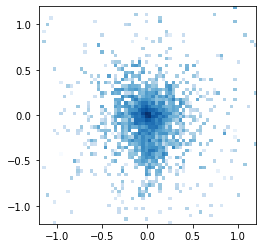

In [17]:
jet_image = getImage(features)
plotImage(jet_image)

### 5) Excercise
Using different hyperparameters, try to generate jet image with 4-momenta data.